In [6]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
df.head()

,Ticker,Last_Price,Quantity,Position_Value
0,AAPL,258.059998,18.00,4645.079956
1,AMD,231.687607,18.00,4170.376923
2,ASML,989.070007,6.00,5934.420044
3,BNB-USD,1315.106201,13.09,17214.740173
4,BR50.MI,24.049999,213.00,5122.649837


In [7]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10

,Ticker,Last_Price,Quantity,Position_Value
5,BTC-USD,123355.679688,2.1571,266090.536654
16,META,719.145020,60.0000,43148.701172
7,EQQQ.DE,527.000000,39.0000,20553.000000
8,ETH-USD,4507.845215,4.3100,19428.812876
3,BNB-USD,1315.106201,13.0900,17214.740173
15,MC.PA,575.500000,22.0000,12661.000000
6,DOGE-USD,0.257870,40270.0000,10384.410042
12,IWDE.MI,105.660004,96.0000,10143.360352
21,RACE,478.019989,13.0000,6214.259857
22,TSLA,437.149292,14.0000,6120.090088


In [8]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# # some Ticker should be adjusted for the data source
# port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [9]:
port_list

['BTC-USD',
 'META',
 'EQQQ.DE',
 'ETH-USD',
 'BNB-USD',
 'MC.PA',
 'DOGE-USD',
 'IWDE.MI',
 'RACE',
 'TSLA']

In [10]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [11]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

df_stocks.head()

Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.761078,127.410179,57.299999,383.397308,208.494690,161.780365,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.288239,134.171707,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.288239,135.069366,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.288239,136.276779,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.288239,144.304153,57.060001,379.738556,211.297440,159.226593,30.102667


In [12]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()

Y = returns.copy()
Y.head()

Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-03,0.048625,0.051452,0.067695,0.002808,0.053069,-0.002443,-0.000119,-0.005291,-0.010563,0.029633
2020-01-04,0.016915,0.008955,0.044755,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.015802,0.000089,0.079429,0.000000,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.060009,0.048291,0.018189,0.000000,0.058905,-0.001749,-0.009425,0.018834,-0.005278,0.019255
2020-01-07,0.003439,0.050774,-0.012180,0.009539,-0.005268,0.003680,0.002047,0.002163,-0.003799,0.038801


Calculating the portfolio

In [13]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
weights,0.216556,2.990380e-09,0.06521,0.456974,0.002624,2.483346e-09,1.319012e-09,0.017178,0.088485,0.152974


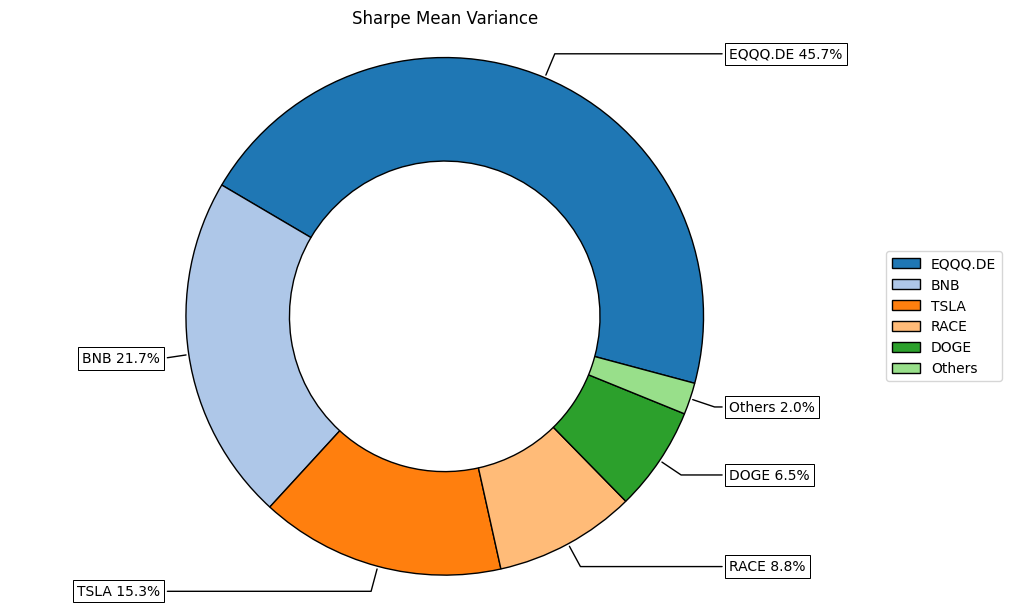

In [14]:
import matplotlib.pyplot as plt

# Plotting the composition of the portfolio
fig_1, ax_1 = plt.subplots(figsize=(10,6))
ax_1 = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                   height=6, width=10, ax=ax_1)

In [15]:
# Calculate efficient frontier
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
0,4.980847e-10,8.749134e-03,3.416559e-10,0.030788,2.332094e-10,8.466102e-01,8.500377e-10,9.962650e-09,0.113853,1.576151e-10
1,7.866381e-02,1.060483e-02,2.407032e-02,0.364054,2.104265e-08,3.228963e-01,1.719374e-08,7.246916e-03,0.170488,2.197638e-02
2,1.197182e-01,2.249238e-03,3.587910e-02,0.499399,3.167068e-08,9.699154e-02,8.375477e-09,7.076982e-03,0.184060,5.462650e-02
3,1.575099e-01,1.551231e-08,4.711746e-02,0.531689,1.163968e-07,1.424977e-08,3.517081e-09,9.602835e-03,0.163953,9.012839e-02
4,1.933656e-01,5.525582e-09,5.808646e-02,0.486455,1.388404e-03,4.513327e-09,2.119975e-09,1.421316e-02,0.118297,1.281936e-01


<Axes: >

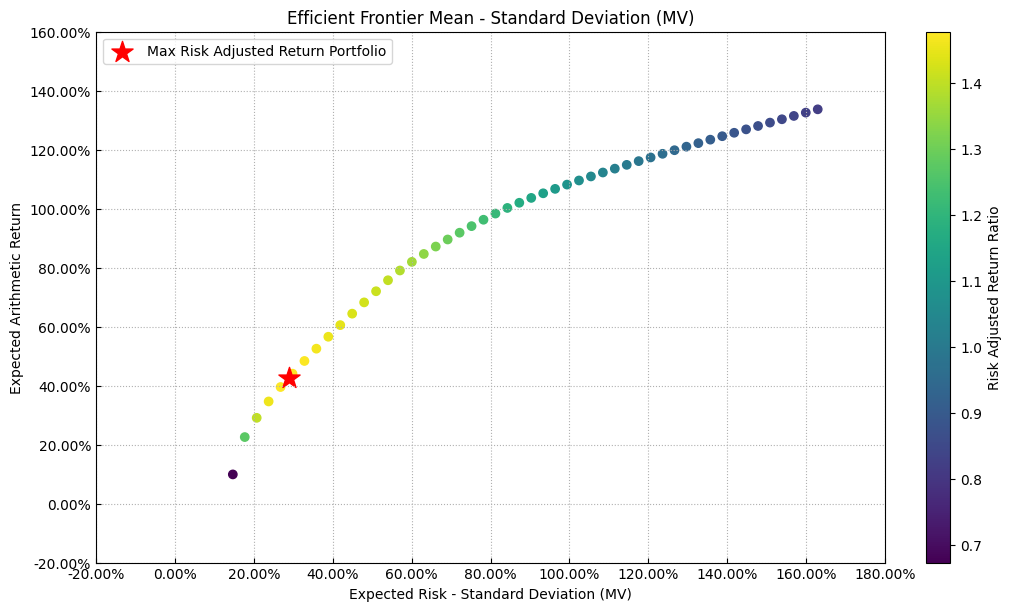

In [16]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig_2, ax_2 = plt.subplots(figsize=(10,6))

rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                 rf=rf, alpha=0.01, cmap='viridis', w=w, label=label,
                 marker='*', s=16, c='r', height=6, width=10, ax=ax_2)

<Axes: title={'center': "Efficient Frontier's Assets Structure"}>

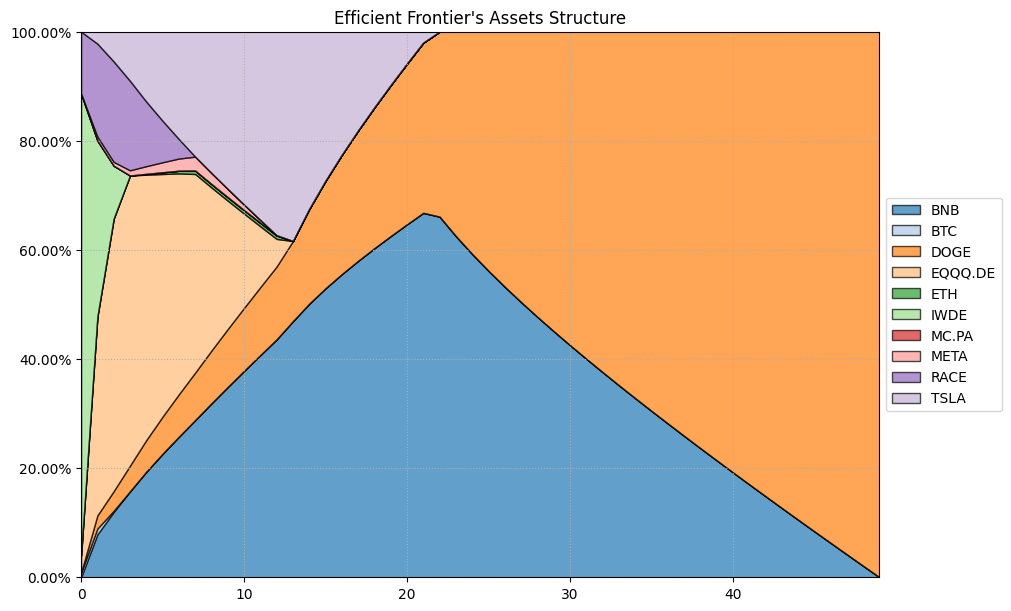

In [17]:
# Plotting efficient frontier composition

fig_3, ax_3 = plt.subplots(figsize=(10,6))

rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=ax_3)